# classical TPA: matrix inverse

In this example a numerical example is used to demonstrate a matrix inverse TPA example with a virtual point transformation at the interface.

In [2]:
import pyFBS

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from matplotlib.colors import LogNorm
%matplotlib inline

## Example datasets

Load the required predefined datasets:

In [3]:
pyFBS.download_lab_testbench()

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 4652.21it/s]

In [4]:
xlsx_pos = r"./lab_testbench/Measurements/TPA_synt.xlsx"

stl_A = r"./lab_testbench/STL/A.stl"
stl_B = r"./lab_testbench/STL/B.stl"
stl_AB = r"./lab_testbench/STL/AB.stl"

df_acc_AB = pd.read_excel(xlsx_pos, sheet_name='Sensors_AB')
df_chn_AB = pd.read_excel(xlsx_pos, sheet_name='Channels_AB')
df_imp_AB = pd.read_excel(xlsx_pos, sheet_name='Impacts_AB')

df_acc_A = pd.read_excel(xlsx_pos, sheet_name='Sensors_A')
df_chn_A = pd.read_excel(xlsx_pos, sheet_name='Channels_A')
df_imp_A = pd.read_excel(xlsx_pos, sheet_name='Impacts_A')

df_acc_B = pd.read_excel(xlsx_pos, sheet_name='Sensors_B')
df_imp_B = pd.read_excel(xlsx_pos, sheet_name='Impacts_B')
df_chn_B = pd.read_excel(xlsx_pos, sheet_name='Channels_B')

df_vp = pd.read_excel(xlsx_pos, sheet_name='VP_Channels')
df_vpref = pd.read_excel(xlsx_pos, sheet_name='VP_RefChannels')

## Numerical model

Load the corresponding .full and .ress file from the example datasets:

In [5]:
full_file_AB = r"./lab_testbench/FEM/AB.full"
ress_file_AB = r"./lab_testbench/FEM/AB.rst"

full_file_B = r"./lab_testbench/FEM/B.full"
ress_file_B = r"./lab_testbench/FEM/B.rst"

 Create an MK model for each component:

In [6]:
MK_AB = pyFBS.MK_model(ress_file_AB, full_file_AB, no_modes=100, recalculate=False)
MK_B = pyFBS.MK_model(ress_file_B ,full_file_B, no_modes=100, recalculate=False)

C:\Users\tomaz.bregar\Anaconda3\lib\site-packages\pyvista\core\pointset.py:610: UserWarning: VTK 9 no longer accepts an offset array
  warnings.warn('VTK 9 no longer accepts an offset array')


The locations and directions of responses and excitations often do not match exactly with the numerical model, so we need to find the nodes closest to these points. Only the locations are updated, the directions remain the same.

In [7]:
df_chn_AB_up = MK_AB.update_locations_df(df_chn_AB)
df_imp_AB_up = MK_AB.update_locations_df(df_imp_AB)

df_chn_B_up = MK_B.update_locations_df(df_chn_B)
df_imp_B_up = MK_B.update_locations_df(df_imp_B)

## 3D view

Open 3D viewer in the background. With the 3D viewer the subplot capabilities of PyVista can be used.

In [8]:
view3D = pyFBS.view3D(show_origin=False, show_axes=False, shape=(1,2), title="TPA")

Add the STL file of structure AB to the 1-1 subplot and show the corresponding accelerometer, channels and impacts.

In [9]:
view3D.plot.subplot(0,0)
view3D.plot.add_text("AB", position='upper_left', font_size=10, color="k", font="times", name="AB_structure")

view3D.add_stl(stl_AB, name="AB_structure", color="#8FB1CC", opacity=.1)
view3D.plot.add_mesh(MK_AB.mesh, scalars=np.zeros(MK_AB.mesh.points.shape[0]), show_scalar_bar=False, name="mesh_AB", cmap="coolwarm", show_edges=True)
view3D.show_chn(df_chn_AB_up, color="green", overwrite=True)
view3D.show_imp(df_imp_AB_up, color="red", overwrite=True);
view3D.show_acc(df_acc_AB, overwrite=True)
view3D.show_vp(df_vp, color="blue", overwrite=True)

Add the STL file of substructure B to the 1-2 subplot and show the corresponding accelerometer, channels and impacts.

In [10]:
view3D.plot.subplot(0,1)
view3D.plot.add_text("B", position='lower_left', font_size=10, color="k", font="times", name="B_structure")

view3D.add_stl(stl_B, name="B_structure", color="#8FB1CC", opacity=.1)
view3D.plot.add_mesh(MK_B.mesh, scalars=np.zeros(MK_B.mesh.points.shape[0]), show_scalar_bar=False, name ="mesh_B", cmap="coolwarm", show_edges=True);
view3D.show_chn(df_chn_B_up, color="green", overwrite=False)
view3D.show_imp(df_imp_B_up, color="red", overwrite=False);
view3D.show_acc(df_acc_B, overwrite=False)
view3D.show_vp(df_vp, color="blue", overwrite=False, scale=1000)

## FRF sythetization

 Perform the FRF sythetization for each component based on the updated locations:

In [11]:
MK_AB.FRF_synth(df_chn_AB_up, df_imp_AB_up, f_start=0, modal_damping=0.003, frf_type="accelerance")
MK_B.FRF_synth(df_chn_B_up, df_imp_B_up, f_start=0, modal_damping=0.003, frf_type="accelerance")

## Virtual point transformation

The VPT can be performed directly on the generated data. First, structural admittance $\boldsymbol{\text{Y}}_{42}^{\text{B}}$ is obtained. VPT is applied here in order to transform excitation forces at the interface into virtual DoF.

In [12]:
vpt_B = pyFBS.VPT(df_chn_B_up[:9], df_imp_B_up[:9], df_vp, df_vpref)

In [13]:
Y42_B = MK_B.FRF[:,:9,:9]@vpt_B.Tf
Y42_B.shape

(2000, 9, 6)

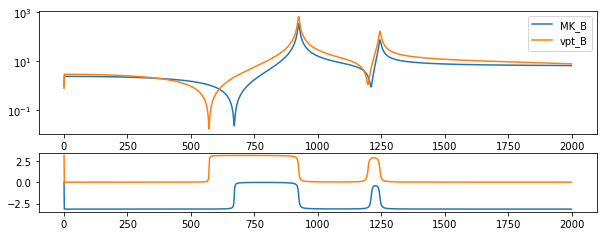

In [14]:
select_out = 2
select_in = 2

plt.figure(figsize = (10,5))
plt.subplot(211)
plt.semilogy(MK_B.freq, np.abs(MK_B.FRF[:,select_out,select_in]), label='MK_B')
plt.semilogy(MK_B.freq, np.abs(Y42_B[:,select_out,select_in]), label='vpt_B')
plt.legend(loc=0)

plt.subplot(413)
plt.plot(MK_B.freq, np.angle(MK_B.FRF[:,select_out,select_in]))
plt.plot(MK_B.freq, np.angle(Y42_B[:,select_out,select_in]));

In second step structural admittance $\boldsymbol{\text{Y}}_{32}^{\text{B}}$ is obtained. VPT is applied here in order to transform excitation forces at the interface into virtual DoF.

In [15]:
MK_B.FRF_synth(df_chn_AB_up,df_imp_B_up,f_start = 0,modal_damping = 0.003,frf_type = "accelerance")

In [16]:
Y32_B = MK_B.FRF[:,9:12,:9]@vpt_B.Tf
Y32_B.shape

(2000, 3, 6)

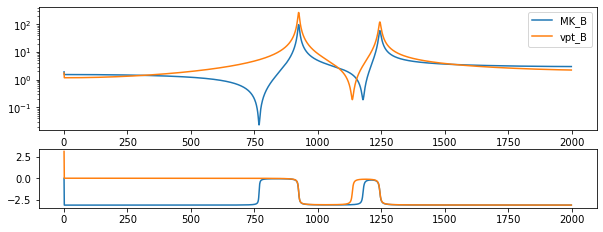

In [17]:
select_out = 2
select_in = 2

plt.figure(figsize = (10,5))
plt.subplot(211)
plt.semilogy(MK_B.freq, np.abs(MK_B.FRF[:,9+select_out,9+select_in]), label='MK_B')
plt.semilogy(MK_B.freq, np.abs(Y32_B[:,select_out,select_in]), label='vpt_B')
plt.legend(loc=0)

plt.subplot(413)
plt.plot(MK_B.freq, np.angle(MK_B.FRF[:,9+select_out,9+select_in]))
plt.plot(MK_B.freq, np.angle(Y32_B[:,select_out,select_in]));

## Aplication of the matrix inverse TPA

Define operational displacements $\boldsymbol{\text{u}}_4$:

In [18]:
imp_loc = 10

u4 = MK_AB.FRF[:, :9, imp_loc:imp_loc+1]
u4.shape

(2000, 9, 1)

Calculate interface forces $\boldsymbol{\text{g}}_2^{\text{B}}$:

In [19]:
g2_B = np.linalg.pinv(Y42_B)@u4

In [20]:
g2_B.shape

(2000, 6, 1)

Displaying interface forces:

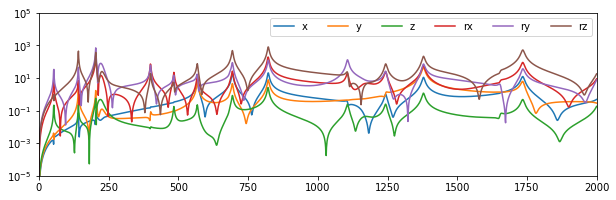

In [21]:
lab = ['x', 'y', 'z', 'rx', 'ry', 'rz']
plt.figure(figsize = (10,3))
for i in range(g2_B.shape[1]):
    plt.semilogy(np.abs(g2_B[:, i, 0]), label=lab[i]);
plt.legend(loc=0, ncol=len(lab));
plt.ylim(10**-5, 10**5)
plt.xlim(0,2000);

Path contributions from interface forces:

In [22]:
sel = 0

u_partial = np.zeros_like(g2_B)

for j in range(g2_B.shape[1]):
    u_partial[:,j:j+1,0:1] = Y32_B[:,sel:sel+1,j:j+1]@g2_B[:,j:j+1,:]

In [23]:
u_partial.shape

(2000, 6, 1)

Contributing paths can be examined using a following display:

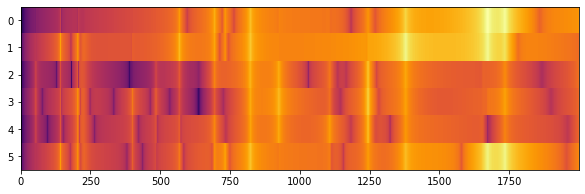

In [24]:
plt.figure(figsize=(10, 3))
values = np.abs(np.reshape(u_partial, (2000, 6))).T[:, 1:]
plt.imshow(values, aspect='auto', cmap=cm.inferno, interpolation='nearest', norm=LogNorm(vmin=np.min(values), vmax=np.max(values)));

Calcualting response $\boldsymbol{\text{u}}_3^{\text{TPA}}$.

In [25]:
u3 = Y32_B @ g2_B
u3.shape

(2000, 3, 1)

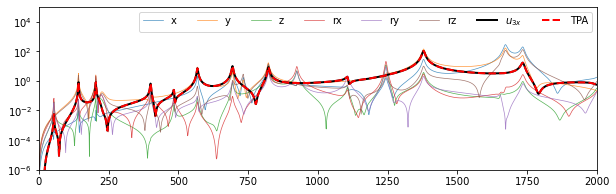

In [26]:
lab = ['x', 'y', 'z', 'rx', 'ry', 'rz']
plt.figure(figsize = (10,3))
for i in range(u_partial.shape[1]):
    plt.semilogy(np.abs(u_partial[:, i, 0]), label=lab[i], lw=0.7, alpha=0.8);
plt.semilogy(np.abs(np.sum(u_partial, axis=1)), 'k', lw=2, label=r'$u_{3x}$')
plt.semilogy(np.abs(u3[:,sel]), '--', color='red', lw=2, label='TPA')
plt.legend(loc=0, ncol=len(lab)+2);
plt.xlim(0, 2000)
plt.ylim(10**-6, 10**5);

On board validation: comparison of predicted $\boldsymbol{\text{u}}_{3}^{\text{TPA}}$ and operational $\boldsymbol{\text{u}}_{3}^{\text{MK}}$:

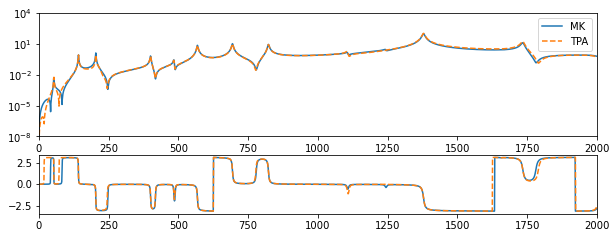

In [27]:
plt.figure(figsize=(10, 5))

u3_MK = MK_AB.FRF[:, 9:12, imp_loc:imp_loc+1]
sel = 0

plt.subplot(211)
plt.semilogy(np.abs(u3_MK[:,sel,0]), label='MK');
plt.semilogy(np.abs(u3[:,sel,0]), '--', label='TPA');
plt.ylim(10**-8, 10**4);
plt.xlim(0, 2000)
plt.legend(loc=0);

plt.subplot(413)
plt.plot(np.angle(u3_MK[:,sel,0]));
plt.plot(np.angle(u3[:,sel,0]), '--');
plt.xlim(0, 2000);